In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xgboost as xgb

In [96]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [97]:
train = pd.read_csv(open('train.csv'), sep = ',')
test = pd.read_csv(open('test.csv'), sep = ',')
train.shape, test.shape

((1460, 81), (1459, 80))

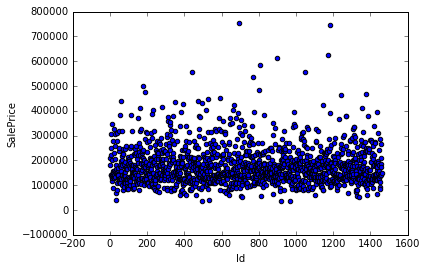

In [98]:
#Scatter plot of Id vs Sale Price
data = train[['Id','SalePrice']].values
#Plot part
plt.scatter(data[:,0],data[:,1]);
plt.xlabel('Id');
plt.ylabel('SalePrice');

In [99]:
type(train),type(test)


(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [100]:
train.isnull().values.any(),train.isnull().sum().sum()

(True, 6965)

In [101]:
train.isnull().values.sum().sum()

6965

In [102]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [103]:
#Concat train and test data so as to avoid mismatch of number of features after applying pandas_dataframe.get_dummies
train_test_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
train_test_data.shape

(2919, 79)

Categorical caolumns

In [104]:
categorical_columns = []
for column in train_test_data.columns.values:
    if train_test_data[column].dtype == 'object':
        categorical_columns.append(column)
    

In [105]:
train_numerical = train_test_data.drop(categorical_columns, axis=1)
train_categorical = train_test_data[categorical_columns]
train_numerical.columns.values, train_categorical.columns.values

(array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'], dtype=object),
 array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Heat

Numerical data imputation

In [106]:
from scipy.stats import skew
from sklearn.preprocessing import Normalizer
for column in train_numerical.columns.values: 
    if(train_numerical[column].isnull().sum() > 100):
        train_numerical = train_numerical.drop(column, axis = 1)
        print "[%s] column is dropped!" %column
    elif (train_numerical[column].isnull().sum().sum() > 0):
        train_numerical = train_numerical.fillna(train_numerical[column].median())
    
        outlier = np.where(is_outlier(train_numerical[column]))
        train_numerical[column].iloc[outlier] = train_numerical[column].median()
    
        if skew(train_numerical[column]) > 0.75:
            train_numerical[column] = np.log(train_numerical[column])
            train_numerical[column] = train_numerical[column].apply(lambda x: 0 if x == -np.inf else x)
        
        train_numerical[column] = Normalizer().fit_transform(train_numerical[column].reshape(1,-1))[0]
    

[LotFrontage] column is dropped!


Categorical data imputation

In [107]:
for column in train_categorical.columns.values:
    if(train_categorical[column].isnull().sum().sum() > 100):
        train_categorical = train_categorical.drop(column, axis = 1)
        print "[%s] column is dropped !" %column
        continue
    elif (train_categorical[column].isnull().sum().sum() > 0):
        train_categorical[column] = train_categorical.fillna(train_categorical[column].value_counts().index[0])

[Alley] column is dropped !


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[FireplaceQu] column is dropped !
[GarageType] column is dropped !
[GarageFinish] column is dropped !
[GarageQual] column is dropped !
[GarageCond] column is dropped !
[PoolQC] column is dropped !
[Fence] column is dropped !
[MiscFeature] column is dropped !


In [108]:
train_categorical.shape

(2919, 34)

In [109]:
#Convert categorical variable into dummy/indicator variables
train_categorical = pd.get_dummies(train_categorical)
train_categorical.shape,train_numerical.shape, type(train_numerical)

((2919, 194), (2919, 35), pandas.core.frame.DataFrame)

In [110]:
#train_test_data_new = train_numerical.join(train_categorical, as_index=False)
train_test_data_new = pd.concat([train_numerical, train_categorical], axis=1)
train_test_data_new.shape, train_numerical.shape, train_categorical.shape

((2919, 229), (2919, 35), (2919, 194))

In [111]:
train_rows = int(train.shape[0] * 0.8)
val_rows = train.shape[0] - train_rows
train_rows, val_rows

(1168, 292)

In [112]:
print train_test_data_new.iloc[:train.shape[0],:].shape, train_test_data_new.shape

(1460, 229) (2919, 229)


In [113]:
#Train partition
xTrain = train_test_data_new.iloc[:train.shape[0],:]
tTrain = train.loc[:train.shape[0] ,'SalePrice']
tTrain = pd.DataFrame(np.log1p(tTrain.values))
"""
xTrain = train_test_data_new.iloc[:train_rows,:]
tTrain = train.loc[:train_rows -1 ,'SalePrice']
"""

"""
#Validation partition
vTrain = train_test_data_new.iloc[train_rows:train.shape[0],:]
vtTrain = train.loc[train_rows:train.shape[0],'SalePrice']
"""


#xTest partition
xTest = train_test_data_new.iloc[train.shape[0]:,:]


In [ ]:
train_test_data_new.shape, xTrain.shape, tTrain.shape, xTest.shape

((2919, 229), (1460, 229), (1460, 1), (1459, 229))

Grid search

In [ ]:
from sklearn import svm, datasets
from sklearn.grid_search import GridSearchCV

"""
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
Bases: xgboost.sklearn.XGBModel, object

Implementation of the scikit-learn API for XGBoost regression.
Parameters
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
missing : float, optional
Value in the data which needs to be present as a missing value. If None, defaults to np.nan.


"""

clf = xgb.XGBRegressor(
        n_estimators = 360,
        learning_rate = 1.0,
        max_depth = 12,
        )
parameters = {
        'n_estimators': [360, 720, 1080],
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [4, 8, 12],
    }
clf = GridSearchCV(clf, parameters, n_jobs=1, cv=2)
    
clf.fit(xTrain, tTrain)
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print(score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
                
print(clf.predict(xTest))

In [ ]:
#T_train_xgb = xgb.DMatrix(xTrain, tTrain)

In [ ]:
"""reg = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
"""

reg = xgb.XGBRegressor(n_estimators=360, max_depth=4, learning_rate=0.1) #the params were tuned using xgb.cv

In [ ]:
#gbm = xgb.train(dtrain=T_train_xgb,params=param)
reg.fit(xTrain, tTrain)


In [ ]:
#Y_pred = gbm.predict(xgb.DMatrix(xTest))
#Y_pred = gbm.predict(xTest)
Y_pred = np.expm1(reg.predict(xTest))
print Y_pred

In [ ]:
print test.loc[:,"Id"].shape, Y_pred.shape

In [ ]:
pred_df = pd.DataFrame(Y_pred, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')